In [1]:
import cobra
from cobra import Model, Reaction, Metabolite
from cobra.medium import minimal_medium
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import exp,log
from matplotlib_venn import venn3,venn2
from functions import *
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from cobra.flux_analysis import production_envelope
import pickle

In [2]:
# save medium for gapfilling
# mdb = pd.read_csv('../data/GSMMs/medium_db.csv')
# mdb.to_csv('../data/GSMMs/medium_db.tsv', sep='\t', encoding='utf-8',index=None)

# Load GSMMs

In [3]:
ref_lb = cobra.io.read_sbml_model('../data/GSMMs/Lactobacillus_delbrueckii_subsp_bulgaricus_ATCC_11842.xml')
ref_st = cobra.io.read_sbml_model('../data/GSMMs/Streptococcus_thermophilus_LMG_18311.xml')
st_ch8 = cobra.io.read_sbml_model('../data/GSMMs/ST_CH8.xml')

In [4]:
# st = cobra.io.read_sbml_model('../data/GSMMs/st_raw.xml')
# lb = cobra.io.read_sbml_model('../data/GSMMs/lb_raw.xml')
st = cobra.io.read_sbml_model('../data/GSMMs/st.xml')
lb = cobra.io.read_sbml_model('../data/GSMMs/lb.xml')

In [5]:
milkAA = pd.read_csv('../data/GSMMs/milkAA.csv')
# milk_desnity = 1.03 #g/ml
# milk_V = (100/1.03)/1000 #L
# concs = []
# for i in range(len(milkAA['aa'])):
#     temp_conc = (float(list(milkAA['concentration(g/100 g milk)'])[i])/aa_mass[ list(milkAA['aa'])[i] ])*1000/milk_V
#     concs.append(temp_conc)
# milkAA['conc(mmol/L)'] = concs
# milkAA.to_csv('../data/GSMMs/milkAA.csv',index=None)

In [6]:
milkAA_free = milkAA[milkAA['type']=='free'].reset_index().drop(['index'],axis=1)
milkAA_total = milkAA[milkAA['type']=='total'].reset_index().drop(['index'],axis=1)

aas = list(milkAA_free['aa'])
aa_mass = {aa:st.metabolites.get_by_id( aa+'_c' ).formula_weight for aa in aas}
print(aa_mass)

{'his__L': 155.15456, 'ile__L': 131.17291999999998, 'leu__L': 131.17291999999998, 'lys__L': 147.1955, 'met__L': 149.21134, 'phe__L': 165.18913999999998, 'thr__L': 119.11916, 'trp__L': 204.22518, 'val__L': 117.14634, 'ala__L': 89.09318, 'arg__L': 175.2089, 'asn__L': 132.11792, 'asp__L': 132.09474, 'cys__L': 121.15818, 'gln__L': 146.1445, 'glu__L': 146.12132, 'gly': 75.0666, 'pro__L': 115.13046, 'ser__L': 105.09258, 'tyr__L': 181.18854}


In [7]:
with open('../data/GSMMs/growth_funcs.pickle', 'rb') as handle:
    growth_funcs= pickle.load(handle)
st_growth = growth_funcs['st']
lb_growth = growth_funcs['lb']
st_EM = st_growth.split('-->')[1].strip() + ' --> ' + st_growth.split('-->')[0]
lb_EM = lb_growth.split('-->')[1].strip() + ' --> ' + lb_growth.split('-->')[0]

# Min medium

In [8]:
vitamins = ['EX_btn_e','EX_pnto__R_e', 'EX_ribflv_e', 'EX_thm_e', 'EX_fol_e']
DNA_materials = ['EX_ade_e', 'EX_gua_e', 'EX_xan_e', 'EX_ura_e']
others = ['EX_mg2_e', 'EX_ca2_e', 'EX_mn2_e', 'EX_fe2_e', 'EX_fe3_e', 'EX_zn2_e', 'EX_cobalt2_e',\
              'EX_cu2_e', 'EX_cl_e', 'EX_so4_e', 'EX_k_e', 'EX_h2o_e', 'EX_h_e', 'EX_pi_e', 'EX_nh4_e']
aa = ['EX_his__L_e', 'EX_ile__L_e', 'EX_leu__L_e', 'EX_lys__L_e', 'EX_met__L_e', 
                     'EX_phe__L_e', 'EX_thr__L_e', 'EX_trp__L_e', 'EX_val__L_e', 'EX_ala__L_e', 
                     'EX_arg__L_e', 'EX_asn__L_e', 'EX_asp__L_e', 'EX_cys__L_e', 'EX_gln__L_e', 
                     'EX_glu__L_e', 'EX_gly_e', 'EX_pro__L_e', 'EX_ser__L_e', 'EX_tyr__L_e', 'EX_orn_e']

In [40]:
with st:
    st.reactions.Growth.build_reaction_from_string(st_growth)
    st.reactions.EM.build_reaction_from_string(st_EM)
    st.reactions.EX_o2_e.lower_bound=0
    st.reactions.EX_caspep_e.lower_bound=0
    st_minmed = minimal_medium(st,0.1,minimize_components=True) 

In [41]:
print(st_minmed)

EX_acgam_e      543.306191
EX_ca2_e          0.001059
EX_cl_e           0.001059
EX_cobalt2_e      0.000020
EX_cu2_e          0.000144
EX_fe3_e          0.002956
EX_k_e            0.039723
EX_met__D_e       0.010512
EX_mg2_e          0.001765
EX_mn2_e          0.000141
EX_pnto__R_e      0.000117
EX_ppi_e          0.076796
EX_ribflv_e       0.000091
EX_so4_e          0.007249
EX_zn2_e          0.000069
dtype: float64


In [38]:
with lb:
    lb.reactions.Growth.build_reaction_from_string(lb_growth)
    lb.reactions.EM.build_reaction_from_string(lb_EM)
    lb.reactions.EX_o2_e.lower_bound=0
    lb.reactions.EX_caspep_e.lower_bound=0
   
    lb_minmed = minimal_medium(lb,0.1,minimize_components=True) 

In [39]:
print(lb_minmed)

EX_abg4_e             0.000127
EX_ala_B_e            0.000110
EX_ca2_e              0.000990
EX_citr__L_e          0.019340
EX_cl_e               0.000990
EX_cobalt2_e          0.000019
EX_cu2_e              0.000135
EX_fe3_e              0.002763
EX_g3pg_e            11.294620
EX_gly_leu_e          0.074442
EX_ile__L_e           6.685267
EX_k_e                0.037133
EX_met_L_ala__L_e     0.011411
EX_mg2_e              0.001650
EX_mn2_e              0.000131
EX_prohisglu_e        0.054898
EX_ribflv_e           0.000085
EX_so4_e              0.000825
EX_trp__L_e           0.005450
EX_tsul_e             6.612413
EX_val__L_e           0.209268
EX_zn2_e              0.000065
dtype: float64


# Validate ST(PA)

In [8]:
freeAA_mM = pd.read_csv('../data/ExpData/freeAA_coculture_mM.csv')
freeAA_mM = freeAA_mM.fillna(0)
freeAA_mM.head()

,AA_ids,Condition,unit,AVG(0),SD(0),AVG(60),SD(60),AVG(105),SD(105),AVG(120),SD(120),AVG(180),SD(180),AVG(300),SD(300)
0,asn__L,coculture,mM,0.018777,0.001094,0.013564,0.001314,0.019913,0.005510,0.018243,0.002162,0.024279,0.004128,0.032366,0.003747
1,gln__L,coculture,mM,0.020700,0.005824,0.013764,0.002575,0.047377,0.017994,0.033912,0.003341,0.015642,0.003157,0.008852,0.002108
2,ser__L,coculture,mM,0.138257,0.041915,0.061109,0.035222,0.106477,0.110900,0.045229,0.023073,0.065105,0.067812,0.051187,0.031631
3,gly,coculture,mM,0.156974,0.006386,0.062351,0.028035,0.060068,0.060874,0.035957,0.013085,0.047476,0.040493,0.047550,0.029393
4,asp__L,coculture,mM,0.032440,0.001543,0.020510,0.010353,0.031100,0.024131,0.039689,0.006045,0.013252,0.010777,0.008241,0.005986


In [9]:
ic = {'st':0.0174*100/101,'lb':0.0174/101,'lac__L_e':0 } #g/L

for i in range(len(freeAA_mM['AA_ids'])):
    ic[ list(freeAA_mM['AA_ids'])[i]+'_e' ] = list(freeAA_mM['AVG(0)'])[i]
ic['for_e']= 2

print(ic)

{'st': 0.017227722772277226, 'lb': 0.00017227722772277226, 'lac__L_e': 0, 'asn__L_e': 0.0187771651264264, 'gln__L_e': 0.0206995131530779, 'ser__L_e': 0.138256763703013, 'gly_e': 0.156974206904269, 'asp__L_e': 0.0324397474115926, 'glu__L_e': 0.2749309956959052, 'thr__L_e': 0.0342527600093889, 'ala__L_e': 0.0875451970622218, 'pro__L_e': 0.0413638580094268, 'lys__L_e': 0.0226669972927161, 'tyr__L_e': 0.0144026769021926, 'met__L_e': 0.0, 'val__L_e': 0.0329939458629266, 'ile__L_e': 0.0131575938082342, 'leu__L_e': 0.0163338591532459, 'phe__L_e': 0.0078852641281382, 'trp__L_e': 0.0062848273655579, 'his__L_e': 0.0, 'arg__L_e': 0.0, 'cys__L_e': 0.0, 'orn_e': 0.0351045009096717, 'for_e': 2}


In [10]:
st_pa_params = get_pa_params( '../data/GSMMs/pa_params.csv', 'st')

In [11]:
#REF:https://sfamjournals.onlinelibrary.wiley.com/doi/full/10.1046/j.1365-2672.2001.01469.x
optMin_profile = {'lac__L_e': 0,'ile__L_e':0.05*1000/131.2,'leu__L_e':0.1*1000/131.2,'met__L_e':0.06*1000/149.2,
                 'val__L_e': 0.2*1000/117.1, 'gln__L_e':0.2*1000/146.1, 'cys__L_e':0.15*1000/121.2 }
for i in range(len(freeAA_mM['AA_ids'])):
    if list(freeAA_mM['AA_ids'])[i]+'_e' not in optMin_profile:
        optMin_profile[ list(freeAA_mM['AA_ids'])[i]+'_e' ] = 0  

complete_CDM = {'lac__L_e': 0,'asp__L_e':0.46,'asn__L_e':0.35,'glu__L_e':0.4,'gln__L_e':0.39,'lys__L_e':0.44,'arg__L_e':0.13,
                'his__L_e':0.15, 'pro__L_e':0.68, 'phe__L_e':0.28, 'trp__L_e':0.05, 'met__L_e':0.13, 'ala__L_e':0.24,
                'val__L_e':0.33,'leu__L_e':0.48,'ile__L_e':0.22,'gly_e':0.18,'ser__L_e':0.34,'thr__L_e':0.23,
                'cys__L_e':0.25,'tyr__L_e':0.29,'orn_e':0}#unit is g/L
for k in complete_CDM.keys():
    temp = complete_CDM[k]
    complete_CDM[k] = temp*1000/st.metabolites.get_by_id(k).formula_weight

In [12]:
with st:   
    temp_med = set_loose_medium( optMin_profile, st_pa_params )
    temp_med['EX_gua_e'] = 0
    temp_med['EX_ade_e'] = 0
    temp_med['EX_xan_e'] = 0
    temp_med['EX_fol_e'] = 0
    temp_med['EX_btn_e'] = 0
    st.medium = temp_med
    st.reactions.MTHFC.upper_bound = 5e-3
    pa_expr = set_PA(st,0.46,st_pa_params['a_dict'],st_pa_params['amin_dict'], optMin_profile,
                     st_pa_params['klach_dict'])
    st.reactions.Growth.build_reaction_from_string(st_growth)
    st.reactions.EM.build_reaction_from_string(st_EM)
    fluxes = cobra.flux_analysis.pfba(st)
    print( 'Growth rate = '+ str(fluxes['Growth']) )
    print('Lactose uptake =' + str(fluxes['EX_lcts_e']))
    print('Galactose secretion = ' + str(fluxes['EX_gal_e']))
    print('lactate production = '+ str(fluxes['EX_lac__L_e']))
    print('Acetate production = ' + str(fluxes['EX_ac_e']))
    print('Formate = ' + str(fluxes['EX_for_e']) )
    print('Met uptake = ' + str(fluxes['EX_met__L_e']))

Growth rate = 0.9703239840694824
Lactose uptake =-26.82143504475399
Galactose secretion = 26.416625668249186
lactate production = 44.09106518438466
Acetate production = 1.5627669749414261
Formate = 0.8035641042705431
Met uptake = -0.10200276908271416


In [16]:
# fluxes.to_frame().to_csv('../../Figures/st_fluxes_optMin.csv')

In [17]:
with st:
    
    st.medium = set_loose_medium( complete_CDM, st_pa_params)
    pa_expr = set_PA(st,0.46,st_pa_params['a_dict'],st_pa_params['amin_dict'], complete_CDM,
                     st_pa_params['klach_dict'])
    st.reactions.MTHFC.upper_bound = 5e-3
    st.reactions.Growth.build_reaction_from_string(st_growth)
    st.reactions.EM.build_reaction_from_string(st_EM)
    fluxes = cobra.flux_analysis.pfba(st)
    print( 'Growth rate = '+ str(fluxes['Growth']) )
    print('Lactose uptake =' + str(fluxes['EX_lcts_e']))
    print('Galactose secretion = ' + str(fluxes['EX_gal_e']))
    print('lactate production = '+ str(fluxes['EX_lac__L_e']))
    print('Acetate production = ' + str(fluxes['EX_ac_e']))
    print('Formate = ' + str(fluxes['EX_for_e']) )

Growth rate = 1.1975918501883025
Lactose uptake =-26.522806582808016
Galactose secretion = 26.023183345475726
lactate production = 44.869140270291275
Acetate production = 2.2205163514804918
Formate = 3.147478747880502


In [22]:
# fluxes.to_frame().to_csv('../../Figures/st_fluxes_completeCDM.csv')

In [14]:
with st:
    
    temp_med = set_loose_medium( ic, st_pa_params, if_milk= True)
    temp_med['EX_met__L_e'] = 0
    
    st.medium = temp_med
    pa_expr = set_PA(st,0.46,st_pa_params['a_dict'],st_pa_params['amin_dict'], ic,
                     st_pa_params['klach_dict'])
    st.reactions.Growth.build_reaction_from_string(st_growth)
    st.reactions.EM.build_reaction_from_string(st_EM)
    fluxes = cobra.flux_analysis.pfba(st)
    print( 'Growth rate = '+ str(fluxes['Growth']) )
    print('Lactose uptake =' + str(fluxes['EX_lcts_e']))
    print('Galactose secretion = ' + str(fluxes['EX_gal_e']))
    print('lactate production = '+ str(fluxes['EX_lac__L_e']))
    print('Acetate production = ' + str(fluxes['EX_ac_e']))
    print('Formate = ' + str(fluxes['EX_for_e']) )
    print('PROLYSIS = ' + str(fluxes['PROLYSIS']))

Growth rate = 0.6405866985263249
Lactose uptake =-13.262426289423107
Galactose secretion = 12.995179981710338
lactate production = 23.464650843575246
Acetate production = 0.8901535053155789
Formate = -0.0
PROLYSIS = 0.091


In [20]:
# fluxes.to_frame().to_csv('../../Figures/st_fluxes_casein.csv')

In [43]:
# the initial growth rate of ST in milk is around 0.64 hr^-1, ref:CH8 paper
g_rates = []
for v_pro in np.linspace(0.08,0.1,num=50):
    with st:
        vmax_dict = st_pa_params['Vmax_dict'].copy()
        vmax_dict['PROLYSIS']=v_pro
        st.medium = set_loose_medium( ic, vmax_dict, 
                                 st_pa_params['Km_dict'], st_pa_params['klach_dict'],if_milk= True) 
        pa_expr = set_PA(st,0.5, st_pa_params['a_dict'],st_pa_params['amin_dict'],ic,
                         st_pa_params['klach_dict'] )
        set_cc(st,'st')
        st.reactions.Growth.build_reaction_from_string(st_growth)
        st.reactions.EM.build_reaction_from_string(st_EM)
        fluxes = cobra.flux_analysis.pfba(st)
        g_rates.append( fluxes['Growth'] )    

Text(0.5, 1.0, 'Influence of casein peptide utilization on ST growth rate')

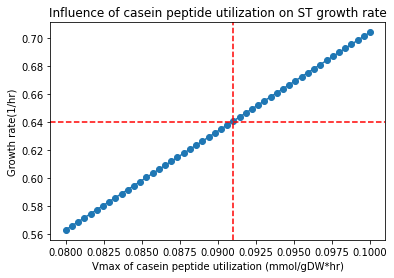

In [44]:
plt.plot( np.linspace(0.08,0.1,num=50),g_rates, marker = 'o')
plt.axhline(y= 0.64, color = 'r', linestyle = '--')
plt.axvline(x=0.091,color = 'r', linestyle = '--')
plt.ylabel('Growth rate(1/hr)')
plt.xlabel('Vmax of casein peptide utilization (mmol/gDW*hr)')
plt.title('Influence of casein peptide utilization on ST growth rate')

In [32]:
a_lcts = st_pa_params['a_dict']['EX_lcts_e']
amin_lcts = st_pa_params['amin_dict']['EX_lcts_e']
observables = {'EX_lcts_e':[],'EX_ac_e':[],'EX_lac__L_e':[],'EX_met__L_e':[],
               'Growth':[],'GALKr':[],
               'lc_prod_pa':[],'ac_prod_pa':[],'acid_transport_pa':[]}

lcts_range = np.concatenate( (np.logspace(-2,-0.2,num=50), np.linspace(0.7,5,num=20) ) )

for lcts_con in lcts_range:
    with st:
        st.medium = set_loose_medium( complete_CDM, st_pa_params)
        a_dict_temp = st_pa_params['a_dict'].copy()
        a_dict_temp['EX_lcts_e'] = a_lcts * lcts_con/(lcts_con+10)#Km = 10mM
        amin_dict_temp = st_pa_params['amin_dict'].copy()
        amin_dict_temp['EX_lcts_e'] = amin_lcts * lcts_con/(lcts_con+10)
        
        pa_expr = set_PA(st,0.46, a_dict_temp ,amin_dict_temp, complete_CDM, st_pa_params['klach_dict'] )
        
        st.reactions.Growth.build_reaction_from_string(st_growth)
        st.reactions.EM.build_reaction_from_string(st_EM)
        fluxes = cobra.flux_analysis.pfba(st)
        for obs in observables.keys():
            if '_pa' not in obs:
                observables[obs].append( fluxes[obs] )
        sigma = 0.5
        observables['lc_prod_pa'].append( fluxes['LDH_L']/(sigma*st_pa_params['a_dict']['LDH_L']) )
        observables['ac_prod_pa'].append( abs(fluxes['EX_ac_e']) * ( 1/(sigma*abs(st_pa_params['a_dict']['PFL'])) +\
                        1/(sigma*abs(st_pa_params['a_dict']['PTAr'])) + 1/(sigma*abs(st_pa_params['a_dict']['ACKr'])) ) )
        
        observables['acid_transport_pa'].append( fluxes['EX_lac__L_e']/(sigma*st_pa_params['a_dict']['EX_lac__L_e']) +\
                            fluxes['EX_ac_e']/(sigma*st_pa_params['a_dict']['EX_ac_e']) )
        

In [33]:
ac_yield = [ -1*observables['EX_ac_e'][i]/observables['EX_lcts_e'][i] for i in range(50)]
lac_yield = [ -1*observables['EX_lac__L_e'][i]/observables['EX_lcts_e'][i] for i in range(50)]
gal_ratio = [ -1*observables['GALKr'][i]/observables['EX_lcts_e'][i] for i in range(50)]
lactose_uptake = [-1*observables['EX_lcts_e'][i] for i in range(50)]
lcts_cost = [(-st_pa_params['a_dict']['EX_lcts_e'] * lcts_range[i]/(lcts_range[i]+10)) for i in range(50)  ]

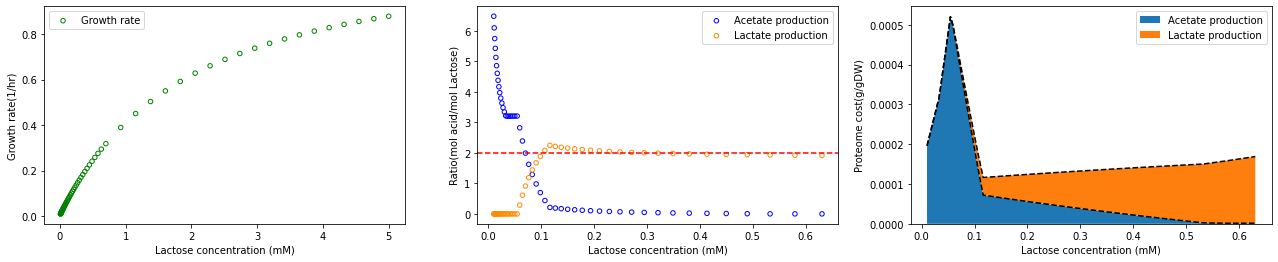

In [41]:
fig, axs = plt.subplots(1,3,figsize=(22,4))
axs[0].scatter( lcts_range,observables['Growth'],label='Growth rate',facecolors='none',
               edgecolors='g',s=20)
axs[0].set_xlabel('Lactose concentration (mM)')
axs[0].set_ylabel('Growth rate(1/hr)')

axs[1].scatter( lcts_range[0:50],ac_yield,label='Acetate production',facecolors='none',
               edgecolors='b',s=20)
axs[1].scatter( lcts_range[0:50],lac_yield,label='Lactate production', facecolors='none',
               edgecolors='darkorange',s=20)
axs[1].set_xlabel('Lactose concentration (mM)')

axs[2].stackplot(lcts_range[0:50],
                 [observables['ac_prod_pa'][0:50],observables['lc_prod_pa'][0:50] ], 
                labels=['Acetate production','Lactate production'] )
axs[2].plot(lcts_range[0:50], np.array(observables['ac_prod_pa'][0:50]), color='black',linestyle='--')
axs[2].plot(lcts_range[0:50], np.array(observables['ac_prod_pa'][0:50])+np.array(observables['lc_prod_pa'][0:50]) ,
            color='black',linestyle='--')

axs[2].set_xlabel('Lactose concentration (mM)')
axs[2].set_ylabel('Proteome cost(g/gDW)')
for ax in axs:
    ax.legend()

axs[1].set_ylabel('Ratio(mol acid/mol Lactose)')
axs[1].axhline(y = 2, color = 'r', linestyle = '--')
    
# plt.suptitle('Metabolic change of ST in response to lactose level')
plt.savefig('../../Figures/metabolic_change_st.svg',format='svg',dpi=150)

In [13]:
with st:
    a_lcts = st_pa_params['a_dict']['EX_lcts_e']
    amin_lcts = st_pa_params['amin_dict']['EX_lcts_e']
    lcts_con = 0.01
    st.medium = set_loose_medium( complete_CDM, st_pa_params)
    a_dict_temp = st_pa_params['a_dict'].copy()
    a_dict_temp['EX_lcts_e'] = a_lcts * lcts_con/(lcts_con+10)#Km = 10mM
    amin_dict_temp = st_pa_params['amin_dict'].copy()
    amin_dict_temp['EX_lcts_e'] = amin_lcts * lcts_con/(lcts_con+10)

    pa_expr = set_PA(st,0.46, a_dict_temp ,amin_dict_temp, complete_CDM, st_pa_params['klach_dict'] )

    st.reactions.Growth.build_reaction_from_string(st_growth)
    st.reactions.EM.build_reaction_from_string(st_EM)
    fluxes = cobra.flux_analysis.pfba(st)
    print(fluxes['Growth'])

0.009006818536394772


In [18]:
# fluxes.to_frame().to_csv('../../Figures/st_fluxes_cCDM_lowlcts.csv')

# Validate LB(PA)

In [13]:
#MPL medium in doi: 10.1128/aem.66.12.5306-5311.2000, Growth rate of LB is ~ 0.7/hr
MPL_medium = {'asn__L_e':2.27, 'gln__L_e':2, 'ser__L_e':3.42, 'gly_e':2.13, 'asp__L_e':3.75, 'glu__L_e':2.25, 
              'thr__L_e':2.52, 'ala__L_e':1.12, 'pro__L_e':8, 'lys__L_e':2.4, 'tyr__L_e':0.66, 
              'met__L_e':0.8, 'val__L_e':4, 'ile__L_e':2.75, 'leu__L_e':4.57, 'phe__L_e':2.06, 
              'trp__L_e':0.5, 'his__L_e':1.3, 'arg__L_e':1.84, 'cys__L_e':1.6, 'orn_e':0 }
MPL_medium['lac__L_e'] = 0

In [14]:
lb_pa_params = get_pa_params( '../data/GSMMs/pa_params.csv', 'lb')

In [15]:
with lb:
    
    temp_med = set_loose_medium(MPL_medium,lb_pa_params )
    lb.medium = temp_med
    lb.reactions.MTHFC.upper_bound = 5e-3
    pa_expr = set_PA(lb,0.529,lb_pa_params['a_dict'],lb_pa_params['amin_dict'], MPL_medium,
                     lb_pa_params['klach_dict'])
    lb.reactions.Growth.build_reaction_from_string(lb_growth)
    lb.reactions.EM.build_reaction_from_string(lb_EM)
    fluxes = cobra.flux_analysis.pfba( lb )
    print( 'Growth rate = '+ str(fluxes['Growth']) )
    print('Lactose uptake =' + str(fluxes['EX_lcts_e']))
    print('Galactose secretion = ' + str(fluxes['EX_gal_e']))
    print('lactate production = '+ str(fluxes['EX_lac__L_e']))
    print('Acetate production = ' + str(fluxes['EX_ac_e']))

Growth rate = 0.7008288189687926
Lactose uptake =-29.39219405309743
Galactose secretion = 29.118881316792418
lactate production = 56.67970407482629
Acetate production = 0.19969637565940224


In [37]:
# fluxes.to_frame().to_csv('../../Figures/lb_fluxes_mpl.csv')

In [28]:
v_aa_range = np.linspace(0.26,0.32,num = 50)
g_rates = []
for v_aa in v_aa_range:
    with lb:
        temp_params = lb_pa_params.copy()
        temp_params['Vmax_dict']['aa_uptake']=v_aa
        lb.medium = set_loose_medium(MPL_medium, temp_params)
        pa_expr = set_PA(lb,0.529, temp_params['a_dict'] ,temp_params['amin_dict'], MPL_medium,
                     temp_params['klach_dict'] )
        
        set_cc(lb,'lb')
        lb.reactions.Growth.build_reaction_from_string(lb_growth)
        lb.reactions.EM.build_reaction_from_string(lb_EM)
        fluxes = cobra.flux_analysis.pfba( lb )
        g_rates.append(fluxes['Growth'])

Text(0.5, 1.0, 'Influence of amino acid uptake rate on LB growth rate')

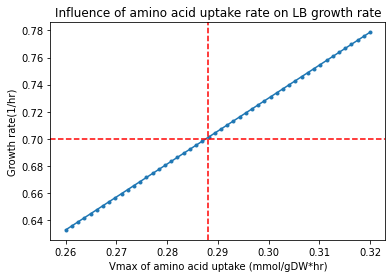

In [34]:
plt.plot( v_aa_range,g_rates,marker = '.')
plt.axhline(y=0.7, color = 'r', linestyle = '--')
plt.axvline(x=0.288,color = 'r', linestyle = '--')
plt.ylabel('Growth rate(1/hr)')
plt.xlabel('Vmax of amino acid uptake (mmol/gDW*hr)')
plt.title('Influence of amino acid uptake rate on LB growth rate')

In [18]:
with lb:
    
    temp_med = set_loose_medium(ic,lb_pa_params, if_milk=True )
    temp_med['EX_ade_e'] = 10
    temp_med['EX_gua_e'] = 10
    temp_med['EX_xan_e'] = 10
    temp_med['EX_for_e'] = 0.3
    lb.medium = temp_med
    lb.reactions.MTHFC.upper_bound = 5e-3
    pa_expr = set_PA(lb,0.529,lb_pa_params['a_dict'],lb_pa_params['amin_dict'],ic,
                     lb_pa_params['klach_dict'])
    set_cc(lb,'lb')
    lb.reactions.Growth.build_reaction_from_string(lb_growth)
    lb.reactions.EM.build_reaction_from_string(lb_EM)
    fluxes = cobra.flux_analysis.pfba( lb )
    print( 'Growth rate = '+ str(fluxes['Growth']) )
    print('Lactose uptake =' + str(fluxes['EX_lcts_e']))
    print('Galactose secretion = ' + str(fluxes['EX_gal_e']))
    print('lactate production = '+ str(fluxes['EX_lac__L_e']))
    print('Acetate production = ' + str(fluxes['EX_ac_e']))
    print('Proteolysis rate = ' + str(fluxes['PROLYSIS']))

Growth rate = 0.8164515288621839
Lactose uptake =-16.200651062189962
Galactose secretion = 15.88224720182635
lactate production = 28.74544304334591
Acetate production = 0.0
Proteolysis rate = 0.652728844129175


In [97]:
# fluxes.to_frame().to_csv('../../Figures/lb_fluxes_milk_plus_difco.csv')

In [83]:
v_pro_range = np.linspace(0.2,0.8,num = 50)
g_rates = []
for v_pro in v_pro_range:
    vmax_dict = lb_pa_params['Vmax_dict'].copy()
    vmax_dict['PROLYSIS'] = v_pro
    with lb:
        temp_med = set_loose_medium(ic,vmax_dict, lb_pa_params['Km_dict'],lb_pa_params['klach_dict'], if_milk=True )
        temp_med['EX_ade_e'] = 10
        temp_med['EX_gua_e'] = 10
        temp_med['EX_xan_e'] = 10
        temp_med['EX_for_e'] = 0.3
        lb.medium = temp_med
        lb.reactions.MTHFC.lower_bound = 0
        lb.reactions.MTHFC.upper_bound = 5e-3
        pa_expr = set_PA(lb,0.529,lb_pa_params['a_dict'],lb_pa_params['Km_dict']['aa_uptake'],ic,
                     lb_pa_params['klach_dict'])
        set_cc(lb,'lb')
        lb.reactions.Growth.build_reaction_from_string(lb_growth)
        lb.reactions.EM.build_reaction_from_string(lb_EM)
        fluxes = cobra.flux_analysis.pfba( lb )
        g_rates.append(fluxes['Growth'])

Text(0.5, 1.0, 'LB')

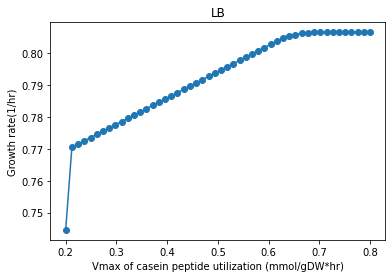

In [84]:
plt.plot(v_pro_range ,g_rates, marker = 'o')
# plt.axhline(y=1.0, color = 'r', linestyle = '--')
# plt.axvline(x=24.18,color = 'r', linestyle = '--')
plt.ylabel('Growth rate(1/hr)')
plt.xlabel('Vmax of casein peptide utilization (mmol/gDW*hr)')
plt.title('LB')

In [75]:
# the growth rate of LB in milk is around 1.0 hr^-1, ref:https://doi.org/10.3168/jds.S0022-0302(86)80701-9

# temp_a = lb_pa_params['a_dict'].copy()
# g_rates = []
# for A_pro in np.linspace(5,10,num=50):
#     temp_a['PROLYSIS'] = A_pro
#     with lb:
#         lb.medium = set_loose_medium(ic , lb_pa_params['Vmax_dict']['aa_uptake'],
#                                      lb_pa_params['Km_dict']['aa_uptake'], if_milk=True )
#         pa_expr = set_PA( lb,0.529,temp_a,lb_pa_params['Km_dict']['aa_uptake'], ic,
#                      lb_pa_params['klach_dict'] )
#         set_cc(lb,'lb')
#         lb.reactions.Growth.build_reaction_from_string(lb_growth)
#         lb.reactions.EM.build_reaction_from_string(lb_EM)
#         fluxes = cobra.flux_analysis.pfba( lb )
#         g_rates.append(fluxes['Growth'])

Text(0.5, 1.0, 'Influence of proteolysis activity on LB growth rate')

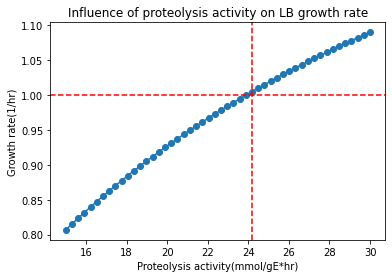

In [83]:
# plt.plot( np.linspace(15,30,num=50),g_rates, marker = 'o')
# plt.axhline(y=1.0, color = 'r', linestyle = '--')
# plt.axvline(x=24.18,color = 'r', linestyle = '--')
# plt.ylabel('Growth rate(1/hr)')
# plt.xlabel('Proteolysis activity(mmol/gE*hr)')
# plt.title('Influence of proteolysis activity on LB growth rate')

In [39]:
a_lcts = lb_pa_params['a_dict']['EX_lcts_e']
amin_lcts = lb_pa_params['amin_dict']['EX_lcts_e']
observables = {'EX_lcts_e':[],'EX_ac_e':[],'EX_lac__L_e':[],'EX_met__L_e':[],
               'Growth':[],'GALKr':[],
               'Glycolysis_pa':[],'lc_prod_pa':[],'ac_prod_pa':[],'acid_transport_pa':[],'gal_uti_pa':[],
              'Growth_pa':[],'lcts_transport_pa':[]}

lcts_range = np.concatenate( (np.logspace(-2,-0.2,num=50), np.linspace(0.7,5,num=20) ) )

for lcts_con in lcts_range:
    with lb:
        lb.medium = set_loose_medium( MPL_medium, lb_pa_params)
        a_dict_temp = lb_pa_params['a_dict'].copy()
        a_dict_temp['EX_lcts_e'] = a_lcts * lcts_con/(lcts_con+10)#Km = 10mM
        amin_dict_temp = lb_pa_params['amin_dict'].copy()
        amin_dict_temp['EX_lcts_e'] = amin_lcts  * lcts_con/(lcts_con+10)
        
        pa_expr = set_PA(lb,0.529, a_dict_temp ,amin_dict_temp, MPL_medium, lb_pa_params['klach_dict'] )
        
        lb.reactions.Growth.build_reaction_from_string(lb_growth)
        lb.reactions.EM.build_reaction_from_string(lb_EM)
        fluxes = cobra.flux_analysis.pfba(lb)
        pa_fracs = get_PA( fluxes, a_dict_temp, amin_dict_temp, MPL_medium, lb_pa_params['klach_dict'] )
        for obs in observables.keys():
            if '_pa' not in obs:
                observables[obs].append( fluxes[obs] )
        observables['Glycolysis_pa'].append( pa_fracs['Glycolysis'] )
        observables['lc_prod_pa'].append( pa_fracs['Lactic acid production'] )
        observables['ac_prod_pa'].append( pa_fracs['Acetic acid production'] )
        observables['acid_transport_pa'].append( pa_fracs['Acid transport'] )
        observables['lcts_transport_pa'].append( pa_fracs['EX_lcts_e'] )
        observables['Growth_pa'].append( pa_fracs['Growth'] )
        observables['gal_uti_pa'].append( pa_fracs['Galactose utilization'] )

In [40]:
ac_yield = [ -1*observables['EX_ac_e'][i]/observables['EX_lcts_e'][i] for i in range(50)]
lac_yield = [ -1*observables['EX_lac__L_e'][i]/observables['EX_lcts_e'][i] for i in range(50)]
gal_ratio = [ -1*observables['GALKr'][i]/observables['EX_lcts_e'][i] for i in range(50)]
lactose_uptake = [-1*observables['EX_lcts_e'][i] for i in range(50)]
lcts_cost = [(-st_pa_params['a_dict']['EX_lcts_e'] * lcts_range[i]/(lcts_range[i]+10)) for i in range(50)  ]

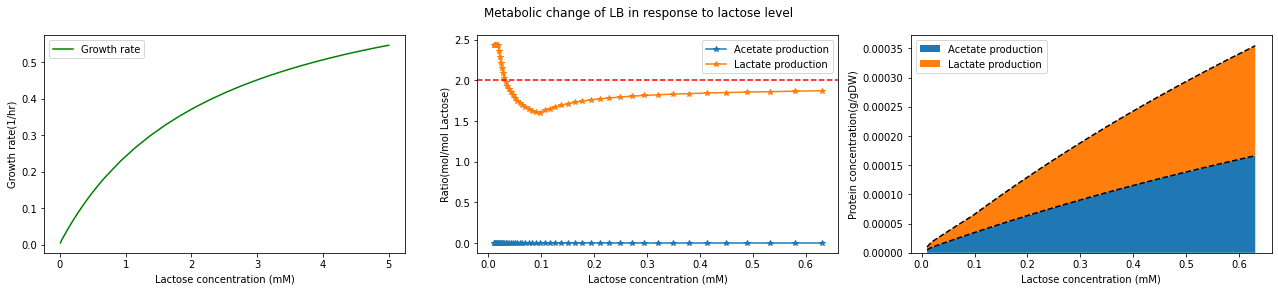

In [41]:
fig, axs = plt.subplots(1,3,figsize=(22,4))
axs[0].plot( lcts_range,observables['Growth'],label='Growth rate',color='g')
axs[0].set_xlabel('Lactose concentration (mM)')
axs[0].set_ylabel('Growth rate(1/hr)')

axs[1].plot( lcts_range[0:50],ac_yield,label='Acetate production',marker = '*')
axs[1].plot( lcts_range[0:50],lac_yield,label='Lactate production', marker = '*')
axs[1].set_xlabel('Lactose concentration (mM)')

axs[2].stackplot(lcts_range[0:50],
                 [observables['ac_prod_pa'][0:50],observables['lc_prod_pa'][0:50]],
                labels=['Acetate production','Lactate production'])

axs[2].plot(lcts_range[0:50], np.array(observables['ac_prod_pa'][0:50]), color='black',linestyle='--')
axs[2].plot(lcts_range[0:50], np.array(observables['ac_prod_pa'][0:50])+np.array(observables['lc_prod_pa'][0:50]) ,
            color='black',linestyle='--')

axs[2].set_xlabel('Lactose concentration (mM)')
axs[2].set_ylabel('Protein concentration(g/gDW)')
axs[2].legend(loc='upper left')

for ax in axs[0],axs[1]:
    ax.legend()

axs[1].set_ylabel('Ratio(mol/mol Lactose)')
axs[1].axhline(y = 2, color = 'r', linestyle = '--')
    
plt.suptitle('Metabolic change of LB in response to lactose level')
plt.savefig('../../Figures/metabolic_change_lb.svg',format='svg',dpi=150)

In [49]:
a_lcts = lb_pa_params['a_dict']['EX_lcts_e']
amin_lcts = lb_pa_params['amin_dict']['EX_lcts_e']
with lb:
    lcts_con = 0.01
    lb.medium = set_loose_medium( MPL_medium, lb_pa_params)
    a_dict_temp = lb_pa_params['a_dict'].copy()
    a_dict_temp['EX_lcts_e'] = a_lcts * lcts_con/(lcts_con+10)#Km = 10mM
    amin_dict_temp = lb_pa_params['amin_dict'].copy()
    amin_dict_temp['EX_lcts_e'] = amin_lcts  * lcts_con/(lcts_con+10)

    pa_expr = set_PA(lb,0.529, a_dict_temp ,amin_dict_temp, MPL_medium, lb_pa_params['klach_dict'] )

    lb.reactions.Growth.build_reaction_from_string(lb_growth)
    lb.reactions.EM.build_reaction_from_string(lb_EM)
    fluxes = cobra.flux_analysis.pfba(lb)
    print(fluxes['Growth'])

0.00525976112015701


In [50]:
# fluxes.to_frame().to_csv('../../Figures/lb_fluxes_mpl_lowlcts.csv')

# Nutrient essentiality
* ST: methionine
* LB: formic acid

In [13]:
non_CDM = complete_CDM.copy()
for k in non_CDM:
    non_CDM[k] = 0   

In [14]:
met_range=np.linspace(0,0.001,num=50)
EX_met_rich, EX_met_non = [],[]
g_rates_rich,g_rates_non =[],[]
for met_con in met_range: 
    temp_ccdm = complete_CDM.copy()
    temp_ncdm = non_CDM.copy()
    temp_ccdm['met__L_e']=met_con
    temp_ncdm['met__L_e']=met_con
    
    with st:
        st.medium = set_loose_medium( temp_ccdm, st_pa_params)
        pa_expr = set_PA(st,0.46,st_pa_params['a_dict'],st_pa_params['amin_dict'], temp_ccdm,
                     st_pa_params['klach_dict'])
        st.reactions.MTHFC.upper_bound = 5e-3
        st.reactions.Growth.build_reaction_from_string(st_growth)
        st.reactions.EM.build_reaction_from_string(st_EM)
        fluxes = cobra.flux_analysis.pfba(st)
        EX_met_rich.append( -1*fluxes['EX_met__L_e'])
        g_rates_rich.append(fluxes['Growth'])
        
    with st:
        st.medium = set_loose_medium( temp_ncdm, st_pa_params)
        pa_expr = set_PA(st,0.46,st_pa_params['a_dict'],st_pa_params['amin_dict'], temp_ncdm,
                     st_pa_params['klach_dict'])
        st.reactions.MTHFC.upper_bound = 5e-3
        st.reactions.Growth.build_reaction_from_string(st_growth)
        st.reactions.EM.build_reaction_from_string(st_EM)
        fluxes = cobra.flux_analysis.pfba(st)
        EX_met_non.append( -1*fluxes['EX_met__L_e'] )
        g_rates_non.append(fluxes['Growth'])

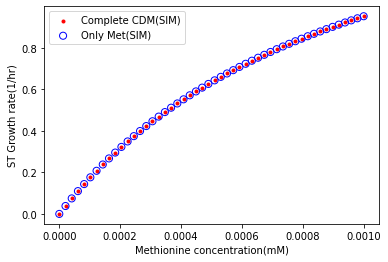

In [15]:
plt.scatter(met_range,g_rates_rich,color='r',marker='.',label='Complete CDM(SIM)' )
plt.scatter(met_range,g_rates_non,facecolors='none',
               edgecolors='b',s=50,label='Only Met(SIM)')
plt.legend()
plt.xlabel('Methionine concentration(mM)')
plt.ylabel('ST Growth rate(1/hr)')
plt.savefig('../../Figures/st_met_gr.svg',format='svg',dpi=150)

In [16]:
aa_range = np.linspace(0,0.001,num=20)
gr_responses = {}
for aa in aa_mass.keys():
    gr_responses[aa] = []
    for aa_con in aa_range:
        temp_ccdm = complete_CDM.copy()
        temp_ccdm[aa+'_e']=aa_con
        with st:
            st.medium = set_loose_medium( temp_ccdm, st_pa_params)
            pa_expr = set_PA(st,0.46,st_pa_params['a_dict'],st_pa_params['amin_dict'], temp_ccdm,
                         st_pa_params['klach_dict'])
            st.reactions.MTHFC.upper_bound = 5e-3
            st.reactions.Growth.build_reaction_from_string(st_growth)
            st.reactions.EM.build_reaction_from_string(st_EM)
            fluxes = cobra.flux_analysis.pfba(st)
            gr_responses[aa].append(fluxes['Growth'])

Text(0.5, 0.9, "The assessment of the requirement of amino acids for ST' growth")

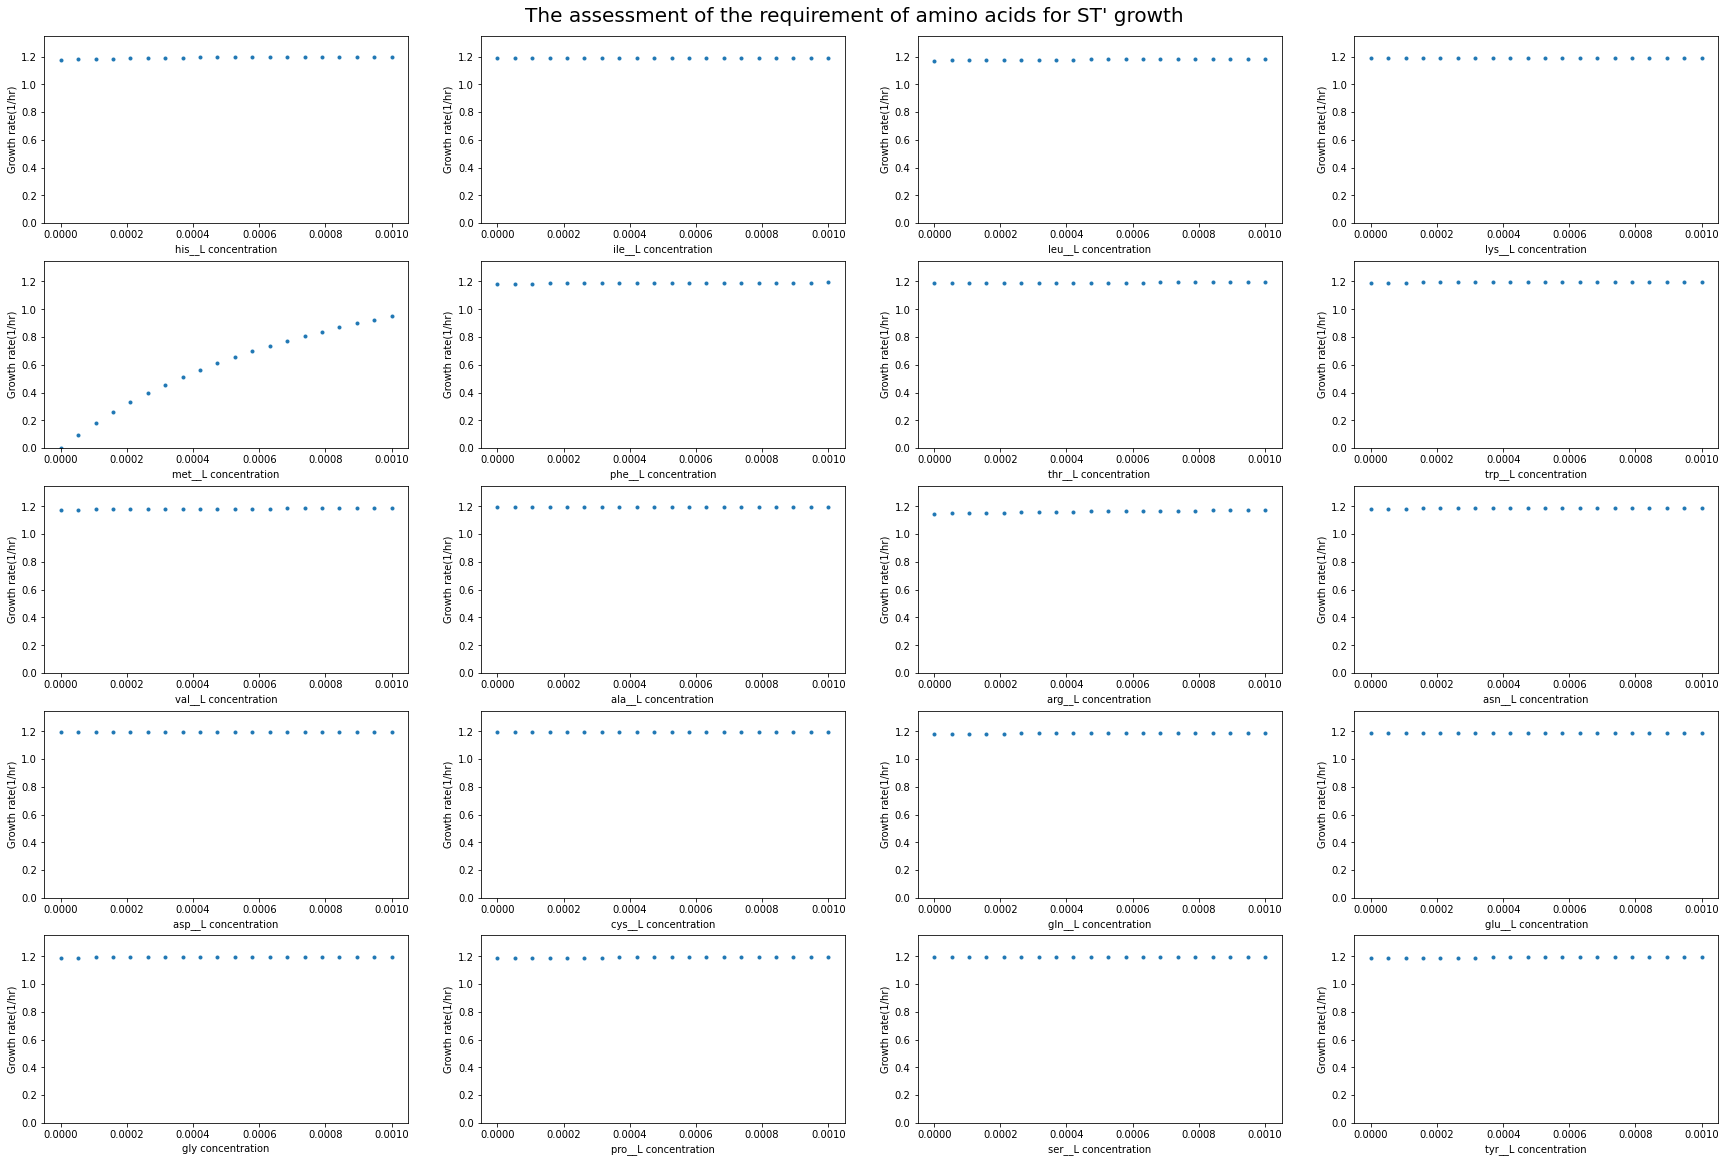

In [45]:
fig, axs = plt.subplots(5,4,figsize=(30,20))
for i in range(20):
    aa = list(aa_mass.keys())[i]
    x,y = int(i/4), int(i%4)
    axs[x][y].scatter(aa_range,gr_responses[aa],marker='.')
    axs[x][y].set_xlabel(aa+' concentration')
    axs[x][y].set_ylabel('Growth rate(1/hr)')
    axs[x][y].set_ylim([0,1.35])
plt.suptitle('The assessment of the requirement of amino acids for ST\' growth',y=0.9,fontsize=20)

In [20]:
aa_range = np.linspace(0,0.001,num=20)
gr_responses = {}
for aa in aa_mass.keys():
    gr_responses[aa] = []
    for aa_con in aa_range:
        temp_mpl = MPL_medium.copy()
        temp_mpl[aa+'_e']=aa_con
        with lb:
            lb.medium = set_loose_medium( temp_mpl, lb_pa_params)
            pa_expr = set_PA(lb,0.529,lb_pa_params['a_dict'],lb_pa_params['amin_dict'],temp_mpl,
                     lb_pa_params['klach_dict'])
            lb.reactions.Growth.build_reaction_from_string(lb_growth)
            lb.reactions.EM.build_reaction_from_string(lb_EM)
            fluxes = cobra.flux_analysis.pfba( lb )
            gr_responses[aa].append(fluxes['Growth'])

Text(0.5, 0.9, "The assessment of the requirement of amino acids for LB' growth")

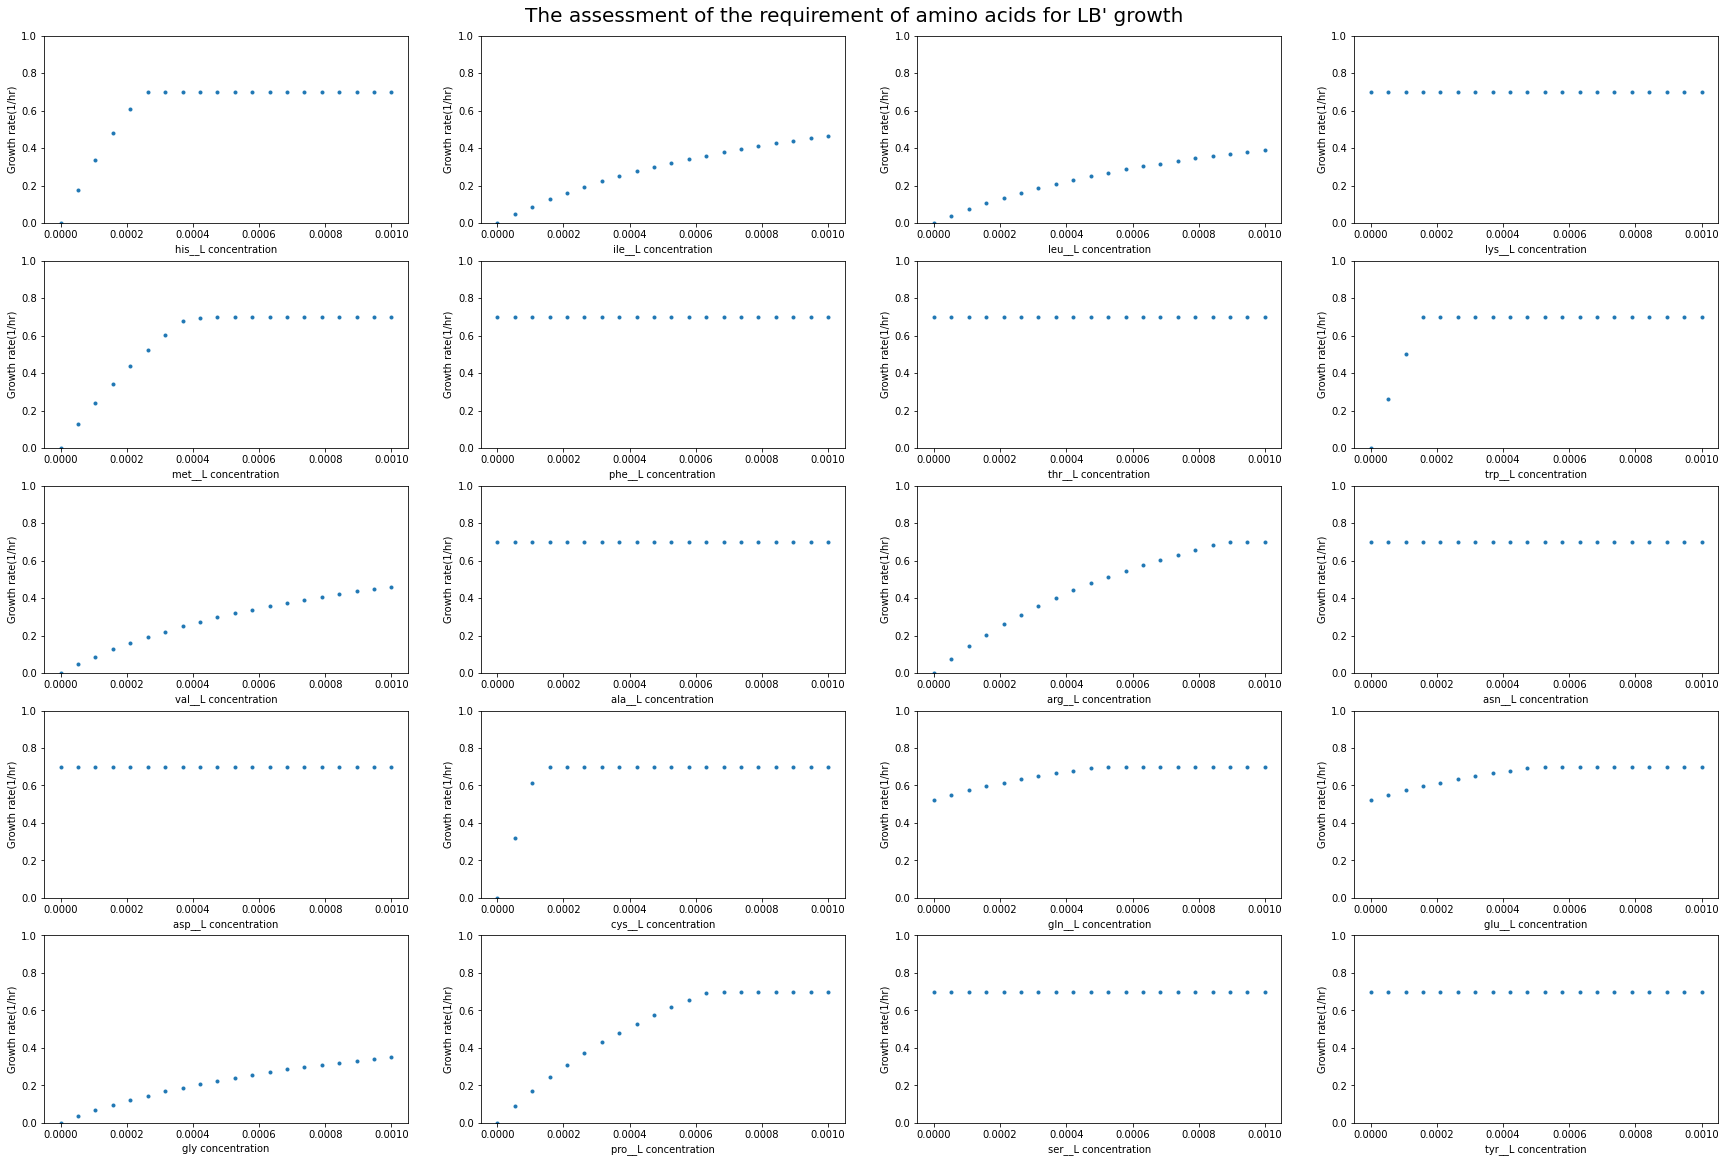

In [21]:
fig, axs = plt.subplots(5,4,figsize=(30,20))
for i in range(20):
    aa = list(aa_mass.keys())[i]
    x,y = int(i/4), int(i%4)
    axs[x][y].scatter(aa_range,gr_responses[aa],marker='.')
    axs[x][y].set_xlabel(aa+' concentration')
    axs[x][y].set_ylabel('Growth rate(1/hr)')
    axs[x][y].set_ylim([0,1])
plt.suptitle('The assessment of the requirement of amino acids for LB\' growth',y=0.9,fontsize=20)

In [25]:
for_range = np.linspace(0,20,num=50)
g_rates_rich,g_rates_non =[],[]
for for_con in for_range:
    with lb:
        temp_med = set_loose_medium(ic,lb_pa_params, if_milk=True )
        temp_med['EX_ade_e'] = 10
        temp_med['EX_gua_e'] = 10
        temp_med['EX_xan_e'] = 10
        temp_med['EX_for_e'] = (for_con*0.3)/(for_con+15)
        lb.medium = temp_med
        lb.reactions.MTHFC.upper_bound = 5e-3
        pa_expr = set_PA(lb,0.529,lb_pa_params['a_dict'],lb_pa_params['amin_dict'],ic,
                     lb_pa_params['klach_dict'])
        lb.reactions.Growth.build_reaction_from_string(lb_growth)
        lb.reactions.EM.build_reaction_from_string(lb_EM)
        fluxes = cobra.flux_analysis.pfba( lb )
        g_rates_rich.append( fluxes['Growth'])
    with lb:
        temp_med = set_loose_medium(ic,lb_pa_params, if_milk=True )
        temp_med['EX_for_e'] = (for_con*0.3)/(for_con+15)
        lb.medium = temp_med
        lb.reactions.MTHFC.upper_bound = 5e-3
        pa_expr = set_PA(lb,0.529,lb_pa_params['a_dict'],lb_pa_params['amin_dict'],ic,
                     lb_pa_params['klach_dict'])
        lb.reactions.Growth.build_reaction_from_string(lb_growth)
        lb.reactions.EM.build_reaction_from_string(lb_EM)
        fluxes = cobra.flux_analysis.pfba( lb )
        g_rates_non.append( fluxes['Growth'])

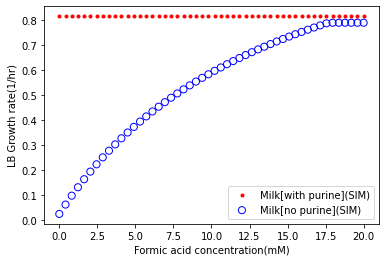

In [27]:
plt.scatter(for_range,g_rates_rich,color='r',marker='.',label='Milk[with purine](SIM)' )
plt.scatter(for_range,g_rates_non,facecolors='none',
               edgecolors='b',s=50,label='Milk[no purine](SIM)')
plt.xlabel('Formic acid concentration(mM)')
plt.ylabel('LB Growth rate(1/hr)')
plt.legend()
plt.savefig('../../Figures/lb_for_gr.svg',format='svg',dpi=150)

# Estimate Amin of Lactose transport
* ST amin of lcts transport is 10, min growth rate at pH=4.5 is 0.1

In [29]:
minA_range = np.linspace(5,20,num=50)
st_grs, lb_grs = [],[]
for minA in minA_range:
    med = complete_CDM.copy()
    med['lac__L_e'] = 150
    
    with st:
        st.medium = set_loose_medium( med, st_pa_params)
        pa_expr = set_PA(st,0.46,st_pa_params['a_dict'],{'EX_lcts_e': -minA}, med, st_pa_params['klach_dict'] )
        st.reactions.Growth.build_reaction_from_string(st_growth)
        st.reactions.EM.build_reaction_from_string(st_EM)
        fluxes = cobra.flux_analysis.pfba(st)
        st_grs.append(fluxes['Growth'])
        
for minA in minA_range:
    med = complete_CDM.copy()
    med['lac__L_e'] = 150
    with lb:
        lb.medium = set_loose_medium( med, lb_pa_params)
        pa_expr = set_PA(lb,0.529,lb_pa_params['a_dict'],{'EX_lcts_e': -minA}, med, lb_pa_params['klach_dict'] )
        lb.reactions.Growth.build_reaction_from_string(lb_growth)
        lb.reactions.EM.build_reaction_from_string(lb_EM)
        fluxes = cobra.flux_analysis.pfba(lb)
        lb_grs.append(fluxes['Growth'])

Text(0.5, 1.0, "Estimation of lactose transporter's minimal activity when inhibited")

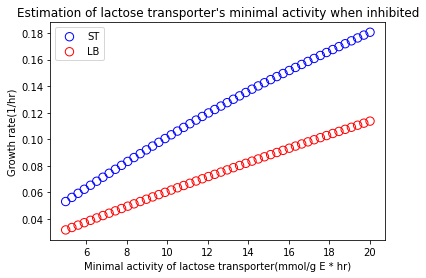

In [48]:
plt.scatter( minA_range,st_grs,label='ST',facecolors='none',
               edgecolors='b',s=70)
plt.scatter( minA_range,lb_grs,label='LB',facecolors='none',
               edgecolors='r',s=70)
plt.ylabel('Growth rate(1/hr)')
plt.xlabel('Minimal activity of lactose transporter(mmol/g E * hr)')
plt.legend()
plt.title('Estimation of lactose transporter\'s minimal activity when inhibited')

In [93]:
lac_con_range = np.linspace(80,130,num=50)

In [94]:
st_grs, lb_grs = [],[]
for lac_con in lac_con_range:
    med = complete_CDM.copy()
    med['lac__L_e'] = lac_con
    with st:
        st.medium = set_loose_medium( med, st_pa_params)
        pa_expr = set_PA(st,0.46,st_pa_params['a_dict'],st_pa_params['amin_dict'], med, st_pa_params['klach_dict'] )
        st.reactions.Growth.build_reaction_from_string(st_growth)
        st.reactions.EM.build_reaction_from_string(st_EM)
        fluxes = cobra.flux_analysis.pfba(st)
        st_grs.append(fluxes['Growth'])
        
for lac_con in lac_con_range:
    med = complete_CDM.copy()
    med['lac__L_e'] = lac_con
    with lb:
        lb.medium = set_loose_medium( med, lb_pa_params)
        pa_expr = set_PA(lb,0.529,lb_pa_params['a_dict'],lb_pa_params['amin_dict'], med, lb_pa_params['klach_dict'] )
        lb.reactions.Growth.build_reaction_from_string(lb_growth)
        lb.reactions.EM.build_reaction_from_string(lb_EM)
        fluxes = cobra.flux_analysis.pfba(lb)
        lb_grs.append(fluxes['Growth'])

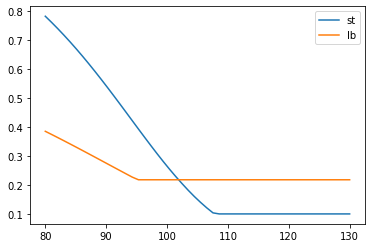

In [95]:
plt.plot(lac_con_range,st_grs,label='st')
plt.plot(lac_con_range,lb_grs,label='lb')
plt.legend()

# model status

In [42]:
st_bd, lb_bd = [ r.id for r in st.boundary], [ r.id for r in lb.boundary]
r_sum = {'st_gpr':0,'st_gapfill':0,'st_boundary':0,'lb_gpr':0,'lb_gapfill':0,'lb_boundary':0}
for r in st.reactions:
    gpr = r.gene_reaction_rule
    if ('s1' in gpr) or ('s2' in gpr) or ('s3' in gpr):
        r_sum['st_gpr'] += 1
    elif r.id in st_bd:
        r_sum['st_boundary'] += 1
    else:
        r_sum['st_gapfill'] += 1
for r in lb.reactions:
    gpr = r.gene_reaction_rule
    if ('s1' in gpr) or ('s2' in gpr) or ('s3' in gpr):
        r_sum['lb_gpr'] += 1
    elif r.id in lb_bd:
        r_sum['lb_boundary'] += 1 
    else:
        r_sum['lb_gapfill'] += 1
labels = ['ST-GSMM','LB-GSMM']
gpr_rxns = np.array([r_sum['st_gpr'],r_sum['lb_gpr']])
gp_rxns = np.array([r_sum['st_gapfill'],r_sum['lb_gapfill'] ])
bd_rxns = np.array([ r_sum['st_boundary'],r_sum['lb_boundary'] ])

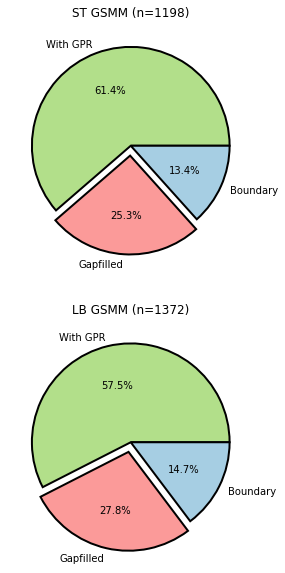

In [43]:
import squarify
st_status,lb_status = {'With GPR': 735,'Gapfilled': 303,'Boundary': 160},{'With GPR': 789,'Gapfilled': 381,'Boundary': 202}
fig,axs = plt.subplots(2,1,figsize=(5,10))
c = [sns.color_palette("Paired")[2], sns.color_palette("Paired")[4],sns.color_palette("Paired")[0]]
explodes=(0,0.1,0)
axs[0].pie(st_status.values(), labels=st_status.keys(),explode=explodes,autopct='%1.1f%%',
           wedgeprops = {"edgecolor" : "black",'linewidth': 2,'antialiased': True},colors=c)
axs[1].pie(lb_status.values(), labels=lb_status.keys(),explode=explodes,autopct='%1.1f%%',
           wedgeprops = {"edgecolor" : "black",'linewidth': 2,'antialiased': True},colors=c)
axs[0].set_title('ST GSMM (n='+str(sum(st_status.values()))+')',fontsize=12)
axs[1].set_title('LB GSMM (n='+str(sum(lb_status.values()))+')',fontsize=12)
plt.savefig('../../Figures/model_status.svg',format='svg',dpi=150)